Fold 1 0

Fold 2 
TCN
Not Found
NNN
Not Found
ANN
Not Found
CNN
Not Found
TAN
Not Found


Fold 3 
CNT
Not Found
ACN
Not Found
NTT
Not Found

Fold 4 
NCC
Not Found
GNC
Not Found
CGN
Not Found
GGN
Not Found

Fold 5 0

In [130]:
from Bio import SeqIO
import torch
import torch.nn as nn
import numpy as np
import itertools
from time import time
import pandas as pd
import multiprocessing
from gensim.models import Word2Vec
import random
import os

SEED = 1234
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

# Function to get 3-nt subsequences
def get_3_nt_subsequences(sequence):
    return [sequence[i:i+3] for i in range(len(sequence) - 2)]

def generate_kmers(path_to_fasta):
    sequences = []
    for seq_record in SeqIO.parse(path_to_fasta, format="fasta"):
        sequences.append(str(seq_record.seq))
    """Generate training data (k-mers) for Word2Vec model."""
    training_data = []
    for sequence in sequences:
        kmers = get_3_nt_subsequences(sequence)
        training_data.append(kmers)
    return training_data
# Flatten the list of subsequences
sequences_corpus_train = generate_kmers("/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_train_SPLIT_1.fasta")
sequences_corpus_test = generate_kmers("/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_1.fasta")

In [135]:
import itertools
# Sanity check 
print(f"Length sequnce corpus TRAIN: {len(sequences_corpus_train)}")
print(f"Length on each sequnce corpus TRAIN: {len(sequences_corpus_train[0])}")
train_corpus_set = set(list(itertools.chain.from_iterable(sequences_corpus_train)))
print(f"Length sequnce corpus TRAIN: {len(sequences_corpus_test)}")
print(f"Length on each sequnce corpus TRAIN: {len(sequences_corpus_test[0])}")
test_corpus_set = set(list(itertools.chain.from_iterable(sequences_corpus_test)))

# for test in test_corpus_set:
#     if test not in train_corpus_set:
#         print(test)
#         print("Not Found")


Length sequnce corpus TRAIN: 103855
Length on each sequnce corpus TRAIN: 999
Length sequnce corpus TRAIN: 27483
Length on each sequnce corpus TRAIN: 999


In [136]:


cores = multiprocessing.cpu_count() 
t = time()
w2v_model = Word2Vec(sentences= sequences_corpus, 
                     window=5,
                     seed=SEED,
                     vector_size=300,
                     workers=(cores//3)*2, # uses 2/3 cores of CPU
                     epochs=10)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 6.86 mins


In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def tsnescatterplot(model, word, topn=5):
    """ 
    MODIFIED from https://github.com/Tsedao/MultiRM
    Plot in seaborn t-SNE dimensionality reduction algorithm of the vectors of a kmers
    """
    arrays = np.empty((0, 300), dtype="f")
    word_labels = [word]
    color_list  = ["blue"]

    # adds the vector of the query word
    # __getitem__ will give (1, dim) instead (dim,) by model.wv[word]
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    positive_words = model.wv.most_similar(positive=[word], topn=topn)
    # adds the vector for each of the closest words to the array
    for wrd_score in positive_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0].replace("T","U"))
        color_list.append("green")
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    negative_words = model.wv.most_similar(negative=[word], topn=topn)
    for wrd_score in negative_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0].replace("T","U"))
        color_list.append("red")
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    # NOTE: Distance means nothing in TSNE. See: https://distill.pub/2016/misread-tsne/
    perplexities = [arrays.shape[0]//4, arrays.shape[0]//3, arrays.shape[0]//2]
    n_perplexities = len(perplexities)

    plt.figure(figsize=(n_perplexities * 4, 4))  # Adjust the figure size as needed
    for i, perplexity in enumerate(perplexities, start=1):
        Y = TSNE(n_components=2, random_state=0, perplexity=perplexity, random_state=SEED, init="pca").fit_transform(arrays)
        df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                        "y": [y for y in Y[:, 1]],
                        "words": word_labels,
                        "color": color_list})

        ax = plt.subplot(1, n_perplexities, i)

        # Basic plot
        p1 = sns.regplot(data=df,
                        x="x",
                        y="y",
                        fit_reg=False,
                        marker="o",
                        scatter_kws={"s": 40,
                                    "facecolors": df["color"]},
                        ax=ax)

        # Adds annotations one by one with a loop
        for line in range(0, df.shape[0]):
            p1.text(df["x"][line],
                    df["y"][line],
                    "  " + df["words"][line],
                    horizontalalignment="left",
                    verticalalignment="bottom", size="medium",
                    color=df["color"][line],
                    weight="normal"
                    ).set_size(12)

        ax.set_xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
        ax.set_ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)
        # Remove ticks and their labels. Distance in tSNE is not meaningful.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("") 
        ax.set_ylabel("") 

        ax.set_title(f"t-SNE with perplexity={perplexity}")
    plt.suptitle(f"TSNE plot for {word}", fontsize=16)
    plt.tight_layout()
    plt.show()


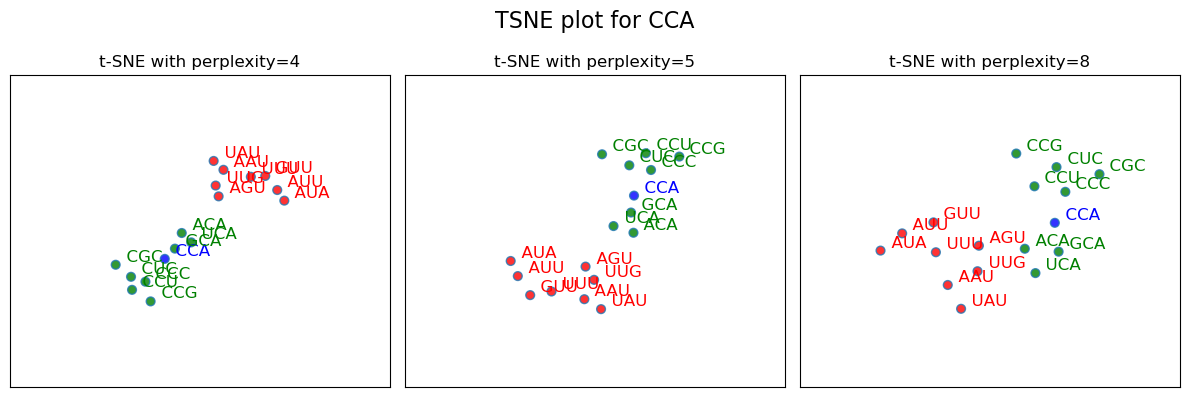

In [222]:
tsnescatterplot(w2v_model, 'CCA', 8)

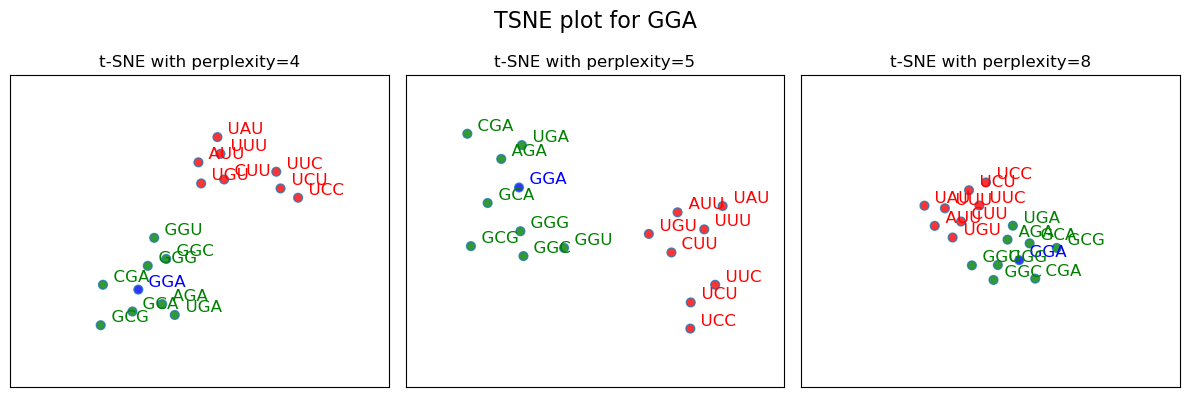

In [223]:
tsnescatterplot(w2v_model, 'GGA', 8)

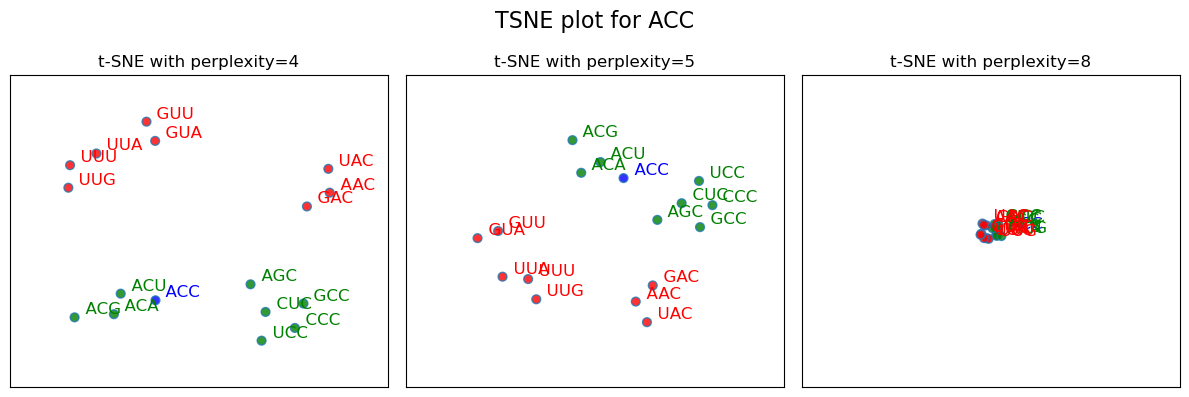

In [224]:
tsnescatterplot(w2v_model, 'ACC', 8)

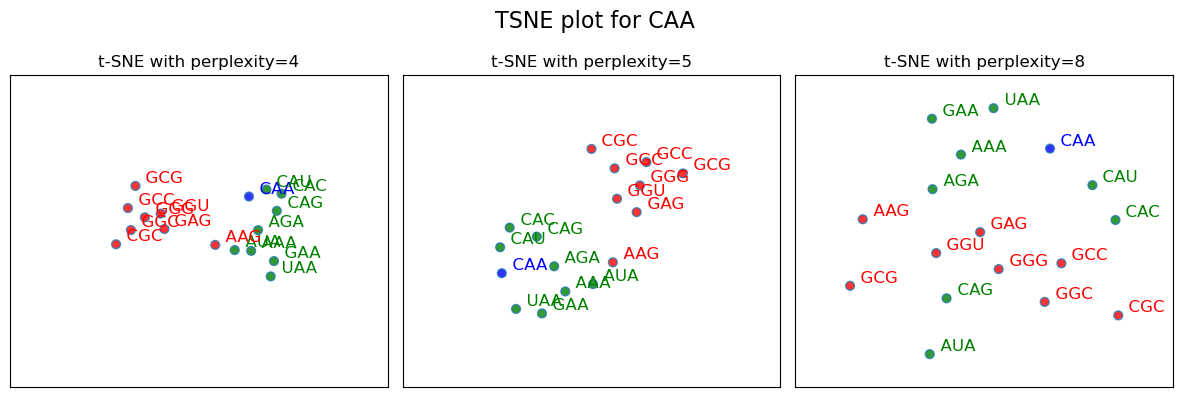

In [225]:
tsnescatterplot(w2v_model, 'CAA', 8)